## SIFT (Scale-Invariant Feature Transform)

### Step 1: Scale-space and DoG Pyramid

C:\Users\c\AppData\Local\Temp\ipykernel_6620\3961832791.py:11: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(url)


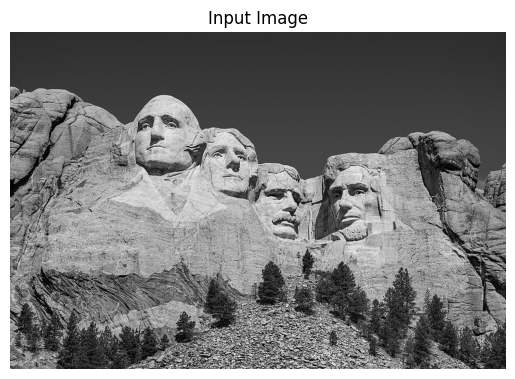

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy.ndimage import gaussian_filter
from skimage import data
from imageio import imread

# Load grayscale image
url = "https://upload.wikimedia.org/wikipedia/commons/thumb/8/87/Mount_Rushmore_detail_view_%28100MP%29.jpg/960px-Mount_Rushmore_detail_view_%28100MP%29.jpg"
image = imread(url)
image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY).astype(np.float32) / 255.0

plt.imshow(image, cmap='gray')
plt.title("Input Image")
plt.axis('off')
plt.show()

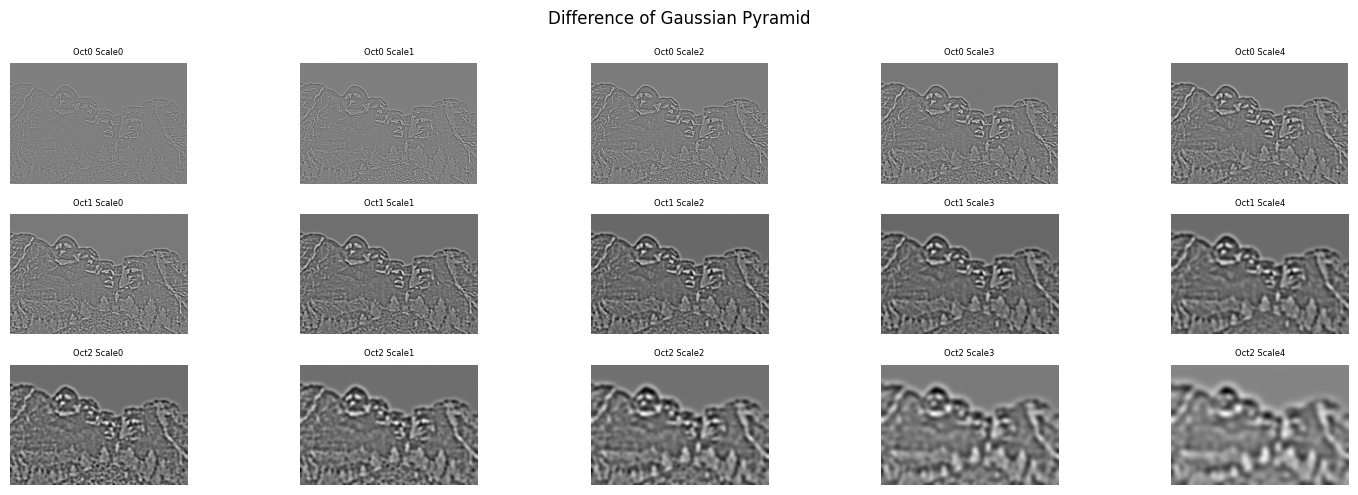

In [3]:
## Step 1a: Gaussian Pyramid
def build_gaussian_pyramid(image, num_octaves=4, num_intervals=3, sigma=1.6):
    pyramid = []
    k = 2 ** (1 / num_intervals)
    for octave in range(num_octaves):
        octave_images = []
        for i in range(num_intervals + 3):  # +3 as per SIFT paper
            curr_sigma = sigma * (k ** i)
            blurred = gaussian_filter(image, sigma=curr_sigma)
            octave_images.append(blurred)
        pyramid.append(octave_images)
        # Downsample for next octave
        image = cv2.resize(image, (image.shape[1] // 2, image.shape[0] // 2), interpolation=cv2.INTER_NEAREST)
    return pyramid

# Step 1b: Build the DoG pyramid from Gaussian pyramid
def build_dog_pyramid(gaussian_pyramid):
    dog_pyramid = []
    for octave in gaussian_pyramid:
        dog_octave = []
        for i in range(1, len(octave)):
            dog = octave[i] - octave[i - 1]
            dog_octave.append(dog)
        dog_pyramid.append(dog_octave)
    return dog_pyramid

# Visualize DoG pyramid
def show_dog(dog_pyramid, num_octaves=3):
    fig, axs = plt.subplots(num_octaves, len(dog_pyramid[0]), figsize=(15, 5))
    for o in range(num_octaves):
        for i in range(len(dog_pyramid[0])):
            axs[o, i].imshow(dog_pyramid[o][i], cmap='gray')
            axs[o, i].axis('off')
            axs[o, i].set_title(f"Oct{o} Scale{i}", fontsize=6)
    plt.suptitle("Difference of Gaussian Pyramid")
    plt.tight_layout()
    plt.show()

# Build and visualize
G = build_gaussian_pyramid(image)
DoG = build_dog_pyramid(G)
show_dog(DoG)

### Step 2: Detect DoG Extrema (Keypoint Candidates)

In [4]:
def is_local_extrema(patch):
    center = patch[1, 1, 1]
    return (center == np.max(patch)) or (center == np.min(patch))

def find_scale_space_extrema(dog_pyramid, contrast_threshold=0.03):
    keypoints = []
    for o, dog_octave in enumerate(dog_pyramid):
        for i in range(1, len(dog_octave)-1):
            prev_img = dog_octave[i-1]
            curr_img = dog_octave[i]
            next_img = dog_octave[i+1]

            h, w = curr_img.shape
            for y in range(1, h-1):
                for x in range(1, w-1):
                    patch = np.stack([
                        prev_img[y-1:y+2, x-1:x+2],
                        curr_img[y-1:y+2, x-1:x+2],
                        next_img[y-1:y+2, x-1:x+2]
                    ])
                    if is_local_extrema(patch):
                        if abs(curr_img[y, x]) > contrast_threshold:
                            keypoints.append((o, i, y, x))
    return keypoints

# Detect keypoints
keypoints = find_scale_space_extrema(DoG)
print(f"Total candidate keypoints detected: {len(keypoints)}")

Total candidate keypoints detected: 650


### Step 3: Orientation Assignment (for visualization)

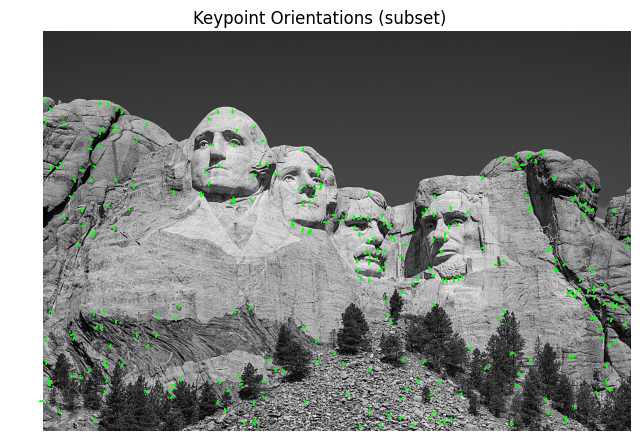

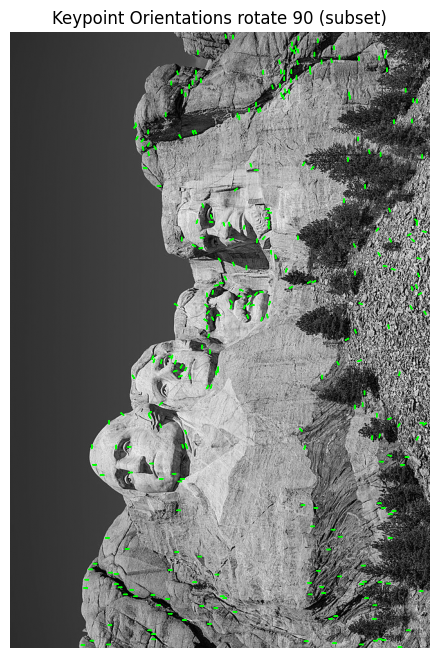

Keypoint orientation differences between original and rotated images:
---------------------------------------------------------------
Keypoint 1: No close match found in rotated image.
---------------------------------------------------------------
Keypoint 2: No close match found in rotated image.
---------------------------------------------------------------
Keypoint 3:
  Original Coordinates: (y=124, x=11)
  Rotated Coordinates: (y=649, x=127)
  Original Orientation: 50°
  Rotated Orientation: 0°
  Orientation Difference: 310°
---------------------------------------------------------------
Keypoint 4:
  Original Coordinates: (y=127, x=310)
  Rotated Coordinates: (y=342, x=122)
  Original Orientation: 90°
  Rotated Orientation: 180°
  Orientation Difference: 90°
---------------------------------------------------------------
Keypoint 5: No close match found in rotated image.
---------------------------------------------------------------
Keypoint 6: No close match found in rotated i

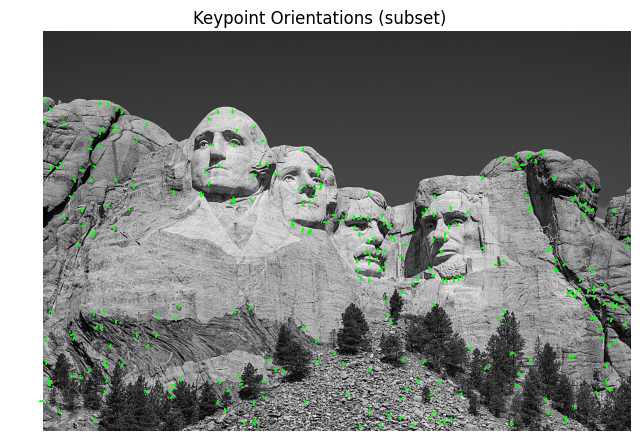

Keypoints in the resized image:


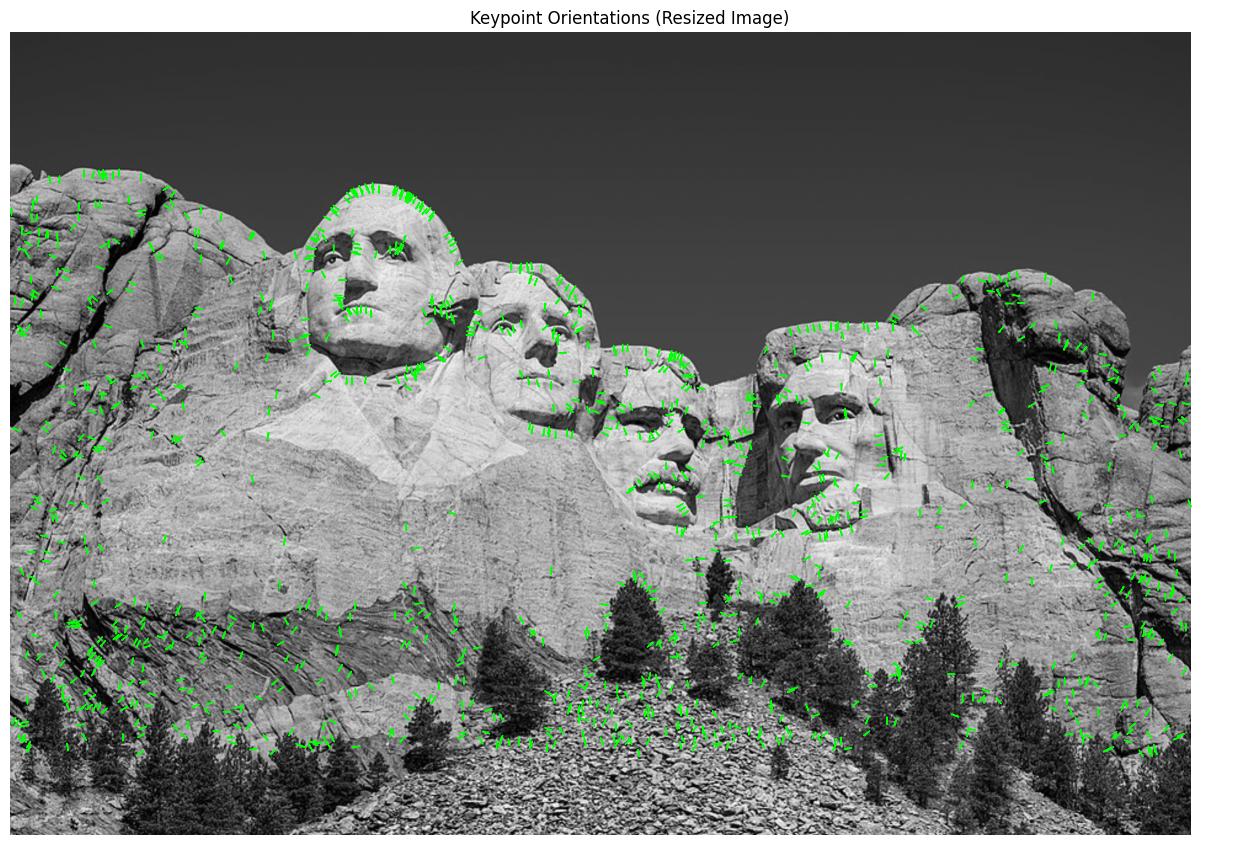

Comparing keypoints between original and resized images:
---------------------------------------------------------------
Keypoint 1: No close match found in resized image.
---------------------------------------------------------------
Keypoint 2: No close match found in resized image.
---------------------------------------------------------------
Keypoint 3:
  Original Coordinates: (y=124, x=11)
  Resized Coordinates: (y=248.00, x=29.00)
  Original Orientation: 50°
  Resized Orientation: 140°
  Scale Difference: 2
---------------------------------------------------------------
Keypoint 4:
  Original Coordinates: (y=127, x=310)
  Resized Coordinates: (y=254.00, x=627.00)
  Original Orientation: 90°
  Resized Orientation: 110°
  Scale Difference: 0
---------------------------------------------------------------
Keypoint 5:
  Original Coordinates: (y=148, x=171)
  Resized Coordinates: (y=294.00, x=344.00)
  Original Orientation: 100°
  Resized Orientation: 100°
  Scale Difference: 0
---

In [68]:
def compute_orientation(image, y, x, radius=8, sigma=1.5):
    patch = image[max(0, y-radius):y+radius+1, max(0, x-radius):x+radius+1]
    dy = ndimage.sobel(patch, axis=0)
    dx = ndimage.sobel(patch, axis=1)
    mag = np.sqrt(dx**2 + dy**2)
    angle = np.arctan2(dy, dx) * 180 / np.pi % 360
    hist, _ = np.histogram(angle, bins=36, range=(0, 360), weights=mag)
    return hist

def visualize_orientations(image, keypoints, gaussian_pyramid):
    plt.figure(figsize=(8, 8))
    plt.imshow(image, cmap='gray')
    for (o, i, y, x) in keypoints[:300]:  # only first 300 for visualization
        g = gaussian_pyramid[o][i]
        hist = compute_orientation(g, y, x)
        dominant_angle = np.argmax(hist) * 10
        dx = np.cos(np.deg2rad(dominant_angle)) * 5
        dy = np.sin(np.deg2rad(dominant_angle)) * 5
        plt.arrow(x, y, dx, dy, color='lime', head_width=1)
    plt.title("Keypoint Orientations (subset)")
    plt.axis('off')
    plt.show()

visualize_orientations(image, keypoints, G)

'''
# Code for 4-3 (a): Rotation Invariance
'''
# made to show the rotated image
def visualize_orientations_rotated(image, keypoints, gaussian_pyramid, rotated=False):
    plt.figure(figsize=(8, 8))
    plt.imshow(image, cmap='gray')
    for (o, i, y, x) in keypoints[:300]:  # only first 300 for visualization
        if rotated:
            # Transform keypoint coordinates for rotated image
            h, w = image.shape
            x, y = y, h - 1 - x

        g = gaussian_pyramid[o][i]
        hist = compute_orientation(g, y, x)
        dominant_angle = np.argmax(hist) * 10
        dx = np.cos(np.deg2rad(dominant_angle)) * 5
        dy = np.sin(np.deg2rad(dominant_angle)) * 5
        plt.arrow(x, y, dx, dy, color='lime', head_width=1)
    plt.title("Keypoint Orientations rotate 90 (subset)")
    plt.axis('off')
    plt.show()

rotated_image = np.rot90(image)
visualize_orientations_rotated(rotated_image, keypoints, G, rotated=True)

from scipy.spatial import cKDTree

def compare_orientation_differences(image, rotated_image, keypoints, keypoints_rotated, gaussian_pyramid, gaussian_pyramid_rotated):
    print("Keypoint orientation differences between original and rotated images:")
    print("---------------------------------------------------------------")

    # Build a KDTree for the rotated keypoints to find nearest matches
    rotated_coords = [(kp[2], kp[3]) for kp in keypoints_rotated]  # (y, x) coordinates
    tree = cKDTree(rotated_coords)

    h, w = image.shape
    for idx, (o, i, y, x) in enumerate(keypoints[:100]):  # Compare the first 100 keypoints
        # Compute orientation for the original image
        g = gaussian_pyramid[o][i]
        hist_original = compute_orientation(g, y, x)
        dominant_original = np.argmax(hist_original) * 10

        # Transform keypoint coordinates for the rotated image
        x_rot, y_rot = y, h - 1 - x

        # Find the nearest keypoint in the rotated image
        dist, nearest_idx = tree.query((y_rot, x_rot), k=1)
        if dist > 10:  # Skip if the nearest keypoint is too far
            print(f"Keypoint {idx + 1}: No close match found in rotated image.")
            print("---------------------------------------------------------------")
            continue

        # Get the corresponding keypoint in the rotated image
        o_r, i_r, y_r, x_r = keypoints_rotated[nearest_idx]

        # Compute orientation for the rotated image
        g_rotated = gaussian_pyramid_rotated[o_r][i_r]
        hist_rotated = compute_orientation(g_rotated, y_r, x_r)
        dominant_rotated = np.argmax(hist_rotated) * 10

        # Calculate the orientation difference
        orientation_difference = (dominant_rotated - dominant_original) % 360

        # Print the results
        print(f"Keypoint {idx + 1}:")
        print(f"  Original Coordinates: (y={y}, x={x})")
        print(f"  Rotated Coordinates: (y={y_r}, x={x_r})")
        print(f"  Original Orientation: {dominant_original}°")
        print(f"  Rotated Orientation: {dominant_rotated}°")
        print(f"  Orientation Difference: {orientation_difference}°")
        print("---------------------------------------------------------------")

# Build the Gaussian Pyramid and detect keypoints for the rotated image
# rotated_image = np.rot90(image)
G_rotated = build_gaussian_pyramid(rotated_image)
DoG_rotated = build_dog_pyramid(G_rotated)
keypoints_rotated = find_scale_space_extrema(DoG_rotated)

# Execute the comparison
compare_orientation_differences(image, rotated_image, keypoints, keypoints_rotated, G, G_rotated)

'''
# Code for 4-3 (b): Scale Invariance
# Resize the image by a factor of 2
'''
from scipy.ndimage import zoom
from scipy.spatial import cKDTree

# Resize the image by a factor of 2 using NumPy
def resize_image(image, scale_factor):
    resized_image = zoom(image, zoom=scale_factor, order=1)  # Bilinear interpolation
    return resized_image


# Visualize keypoints for the resized image without scaling down coordinates
def visualize_orientations_resized(image, keypoints, gaussian_pyramid, figsize=(16, 16)):
    """
    Visualize SIFT keypoints and their orientations for a resized image.

    Parameters:
    - image: Resized image (2D array).
    - keypoints: List of keypoints detected in the resized image.
    - gaussian_pyramid: Gaussian pyramid of the resized image.
    - figsize: Size of the figure for visualization.
    """
    plt.figure(figsize=figsize)
    plt.imshow(image, cmap='gray')
    for (o, i, y, x) in keypoints[:1200]:  # Visualize only the first 1200 keypoints
        # used 1200 keypoints to make the density of keypoints similar to the original image
        # Get the Gaussian image at the corresponding octave and scale
        g = gaussian_pyramid[o][i]
        hist = compute_orientation(g, y, x)
        dominant_angle = np.argmax(hist) * 10

        # Draw the arrow for the keypoint orientation
        dx = np.cos(np.deg2rad(dominant_angle)) * 10
        dy = np.sin(np.deg2rad(dominant_angle)) * 10
        plt.arrow(x, y, dx, dy, color='lime', head_width=2)
    plt.title("Keypoint Orientations (Resized Image)")
    plt.axis('off')
    plt.show()


    
# Resize the original image
resized_image = resize_image(image, scale_factor=2)

# Build Gaussian Pyramid and detect keypoints for the resized image
G_resized = build_gaussian_pyramid(resized_image)
DoG_resized = build_dog_pyramid(G_resized)
keypoints_resized = find_scale_space_extrema(DoG_resized)

# Visualize keypoints for both images
print("Keypoints in the original image:")
visualize_orientations(image, keypoints, G)

print("Keypoints in the resized image:")
visualize_orientations_resized(resized_image, keypoints_resized, G_resized, figsize=(16, 16))

# Compare keypoints between the original and resized images
def compare_keypoints(original_image, resized_image, keypoints, keypoints_resized):
    print("Comparing keypoints between original and resized images:")
    print("---------------------------------------------------------------")

    # Scale down resized image keypoints to match the original image's scale
    resized_coords = [(kp[2] / 2, kp[3] / 2) for kp in keypoints_resized]  # Scale down by factor of 2
    tree = cKDTree(resized_coords)

    for idx, (o, i, y, x) in enumerate(keypoints[:10]):  # Compare the first 10 keypoints
        # Find the nearest keypoint in the resized image
        dist, nearest_idx = tree.query((y, x), k=1)
        if dist > 5:  # Skip if the nearest keypoint is too far
            print(f"Keypoint {idx + 1}: No close match found in resized image.")
            print("---------------------------------------------------------------")
            continue

        # Get the corresponding keypoint in the resized image
        y_r, x_r = resized_coords[nearest_idx]  # Resized coordinates
        o_r, i_r = keypoints_resized[nearest_idx][:2]  # Octave and scale

        # Compare orientations and scales
        g = G[o][i]
        hist_original = compute_orientation(g, y, x)
        dominant_original = np.argmax(hist_original) * 10

        g_resized = G_resized[o_r][i_r]
        hist_resized = compute_orientation(g_resized, int(y_r * 2), int(x_r * 2))  # Scale back to resized image
        dominant_resized = np.argmax(hist_resized) * 10

        print(f"Keypoint {idx + 1}:")
        print(f"  Original Coordinates: (y={y}, x={x})")
        print(f"  Resized Coordinates: (y={y_r * 2:.2f}, x={x_r * 2:.2f})")  # Scale back to resized image
        print(f"  Original Orientation: {dominant_original}°")
        print(f"  Resized Orientation: {dominant_resized}°")
        print(f"  Scale Difference: {abs(o - o_r)}")
        print("---------------------------------------------------------------")

# Compare keypoints
compare_keypoints(image, resized_image, keypoints, keypoints_resized)

### Step 4: SIFT Keypoint Matching (with OpenCV for reference)

Number of keypoints in Image 1: 2897
Number of keypoints in Image 2: 3324
Number of good matches: 0


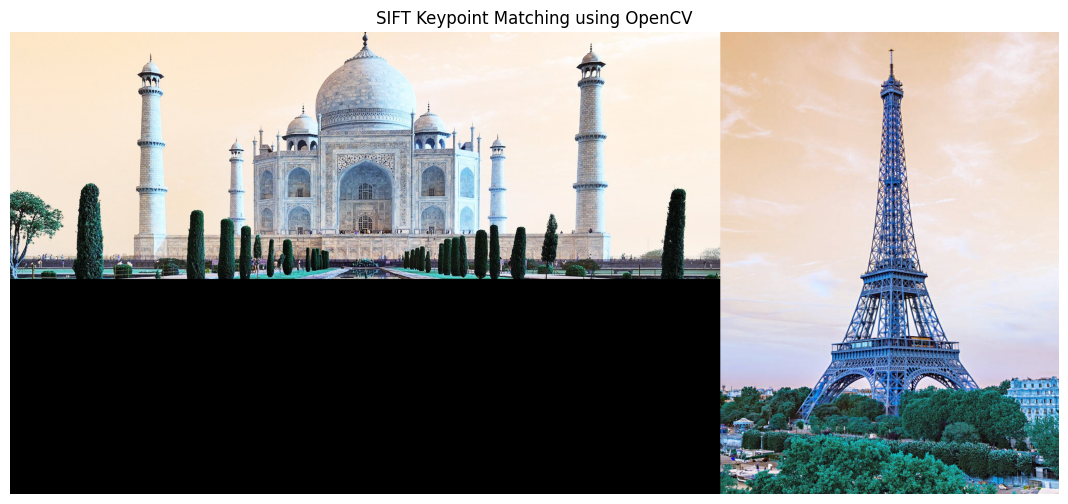

In [12]:
url1 = "https://upload.wikimedia.org/wikipedia/commons/thumb/8/87/Mount_Rushmore_detail_view_%28100MP%29.jpg/960px-Mount_Rushmore_detail_view_%28100MP%29.jpg"
url2 = "https://upload.wikimedia.org/wikipedia/commons/thumb/1/1d/Mount_Rushmore_distant_view.jpg/620px-Mount_Rushmore_distant_view.jpg"

img1 = cv2.imread("4-4c_img1.png")  
img2 = cv2.imread("4-4c_img2.png")       

# img1 = imread(url1)
# img2 = imread(url2)


img1_gray = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
img2_gray = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)

sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute((img1_gray * 255).astype(np.uint8), None)
kp2, des2 = sift.detectAndCompute((img2_gray * 255).astype(np.uint8), None)

bf = cv2.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)

# Apply Lowe's ratio test
good = []
for m, n in matches:
    if m.distance < 0.4 * n.distance:
        good.append([m])

# Code for 4-4 (a): Keypoint Matching
print(f"Number of keypoints in Image 1: {len(kp1)}")
print(f"Number of keypoints in Image 2: {len(kp2)}")
print(f"Number of good matches: {len(good)}")

matched_img = cv2.drawMatchesKnn((img1).astype(np.uint8), kp1,
                                  (img2).astype(np.uint8), kp2,
                                  good, None, flags=2)

plt.figure(figsize=(14, 6))
plt.imshow(matched_img)
plt.axis('off')
plt.title("SIFT Keypoint Matching using OpenCV")
plt.show()
